# Problem 4.2 : Bounding Box connections in a document image

Given bounding boxes of words in a document image, find the connections between the words. The connections are defined as follows:
- Two words are connected if they are in the same line.
- Two words are connected if they are in the same paragraph.
- Words in different columns or paragraphs should not be connected.

In [1]:
# Importing required libraries
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

We select the image tagged 29 as the example for this notebook

In [2]:
target = 29

In [3]:
document_img_path = 'SMAI - AQ2/images/{}.jpg'.format(target)
document_csv_path = 'SMAI - AQ2/CSV/TLBR_{}.csv'.format(target)

In [4]:
# Loading dataframe
df = pd.read_csv(document_csv_path)
df.head()

,Unnamed: 0,Top-Left,Bottom-Right,Id
0,0,"[338, 133]","[469, 185]",0
1,1,"[662, 126]","[795, 178]",1
2,2,"[822, 133]","[923, 185]",2
3,3,"[592, 250]","[694, 314]",3
4,4,"[735, 253]","[846, 308]",4


In [5]:
img = cv2.imread(document_img_path)

The following are scripts given for visualisation of the bounding boxes and the connections between them.

In [6]:
def visualize_bboxes(img):
    img_2 = img.copy()
    for index, rows in df.iterrows():
        top_left = (int(rows['Top-Left'].split(',')[0][1:]), int(rows['Top-Left'].split(',')[1][:-1]))
        bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]), int(rows['Bottom-Right'].split(',')[1][:-1]))
        cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    # Increase the size of the image displayed
    plt.rcParams["figure.figsize"] = (15, 15)
    plt.imshow(img_2)


def make_connections(image, euclidean):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_with_boxes = image_rgb.copy()

    for index, row in euclidean.iterrows():
        left = int(row['Left'][0])
        right = int(row['Right'][0])
        top = int(row['Top'][1])
        bottom = int(row['Bottom'][1])
        box_id = int(row['Id'])

        width = right - left
        height = bottom - top

        top_left = (left, top)
        bottom_right = (right, bottom)

        cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

        label_position = (left, top - 10)
        cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        top_adjacent_id = int(row['Top_Box'][1])
        bottom_adjacent_id = int(row['Bottom_Box'][1])
        left_adjacent_id = int(row['Left_Box'][1])
        right_adjacent_id = int(row['Right_Box'][1])

        if top_adjacent_id != 0:
            top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
            top_adjacent_center = int(top_adjacent_row['Bottom'][0]), int(top_adjacent_row['Bottom'][1])
            cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

        if bottom_adjacent_id != 0:
            bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
            bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]), int(bottom_adjacent_row['Top'][1])
            cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)),
                     (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

        if left_adjacent_id != 0:
            left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
            left_adjacent_center = int(left_adjacent_row['Right'][0]), int(left_adjacent_row['Right'][1])
            cv2.line(image_with_boxes, (int(left), int(top) + height // 2),
                     (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

        if right_adjacent_id != 0:
            right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
            right_adjacent_center = int(right_adjacent_row['Left'][0]), int(right_adjacent_row['Left'][1])
            cv2.line(image_with_boxes, (int(right), int(top) + height // 2),
                     (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

    return image_with_boxes

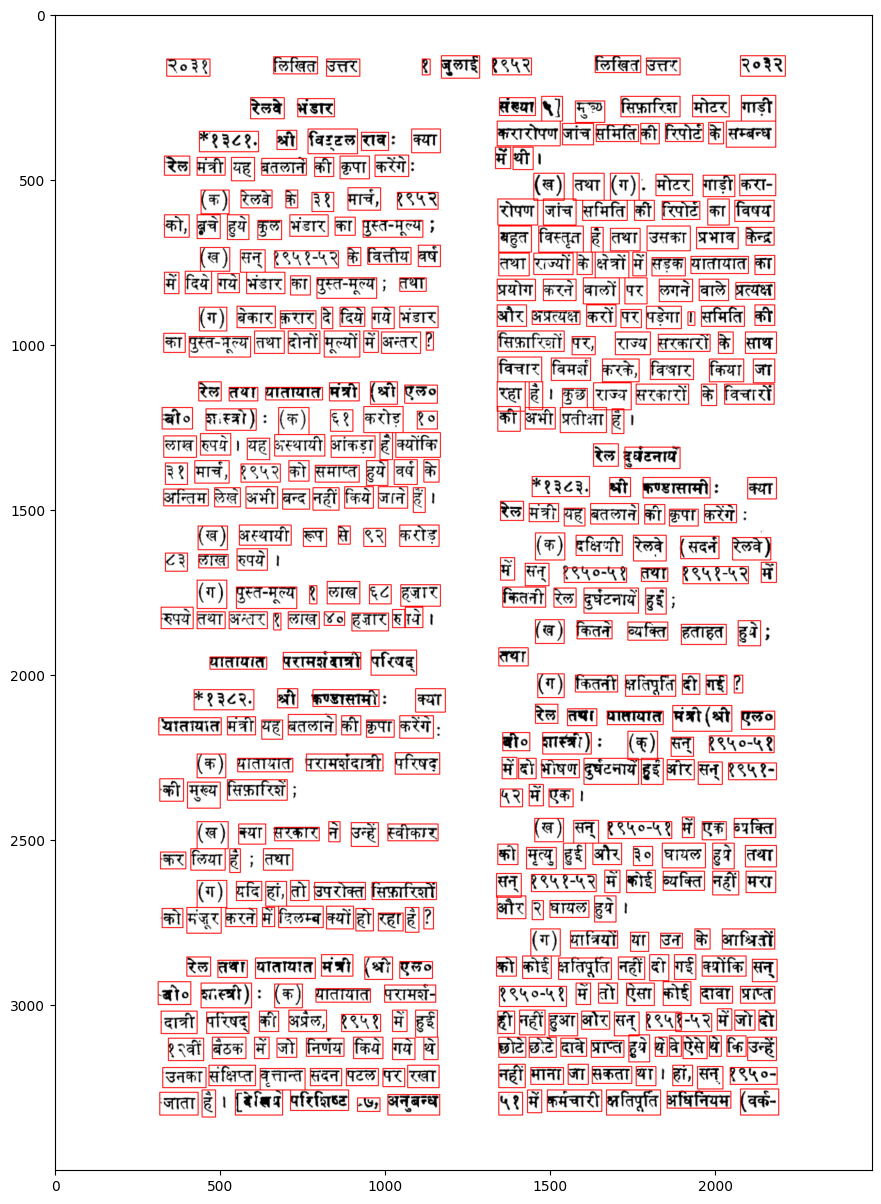

In [7]:
visualize_bboxes(img)

Now we define functions to transform the dataframe in the required format. 

1. We add the columns for the center of the edges of the bounding boxes.
2. We add the connected boxes to the connection columns.

Later we will look at a heuristic to find the thresholds for the connections.

In [8]:
def add_columns(data):
    data_copy = data.copy()
    data_copy['Top-Left'] = data_copy['Top-Left'].apply(lambda x: [int(t) for t in x[1:-1].split(', ')])
    data_copy['Bottom-Right'] = data_copy['Bottom-Right'].apply(lambda x: [int(t) for t in x[1:-1].split(', ')])

    x1 = data_copy['Top-Left'].apply(lambda x: x[0])
    x2 = data_copy['Bottom-Right'].apply(lambda x: x[0])
    y1 = data_copy['Bottom-Right'].apply(lambda x: x[1])
    y2 = data_copy['Top-Left'].apply(lambda x: x[1])

    data_copy['Top-x'] = (x1 + x2) / 2.0
    data_copy['Top-y'] = y2
    data_copy['Bottom-x'] = (x1 + x2) / 2.0
    data_copy['Bottom-y'] = y1
    data_copy['Left-x'] = x1
    data_copy['Left-y'] = (y1 + y2) / 2.0
    data_copy['Right-x'] = x2
    data_copy['Right-y'] = (y1 + y2) / 2.0
    
    # Edge center columns
    data_copy['Top'] = [[row['Top-x'], row['Top-y']] for index, row in data_copy.iterrows()]
    data_copy['Bottom'] = [[row['Bottom-x'], row['Bottom-y']] for index, row in data_copy.iterrows()]
    data_copy['Left'] = [[row['Left-x'], row['Left-y']] for index, row in data_copy.iterrows()]
    data_copy['Right'] = [[row['Right-x'], row['Right-y']] for index, row in data_copy.iterrows()]
    data_copy.drop(columns=['Top-x', 'Top-y', 'Bottom-x', 'Bottom-y', 'Left-x', 'Left-y', 'Right-x', 'Right-y'], inplace=True)
    return data_copy

In [9]:
df_fixed = add_columns(df)
df_fixed.head()

,Unnamed: 0,Top-Left,Bottom-Right,Id,Top,Bottom,Left,Right
0,0,"[338, 133]","[469, 185]",0,"[403.5, 133]","[403.5, 185]","[338, 159.0]","[469, 159.0]"
1,1,"[662, 126]","[795, 178]",1,"[728.5, 126]","[728.5, 178]","[662, 152.0]","[795, 152.0]"
2,2,"[822, 133]","[923, 185]",2,"[872.5, 133]","[872.5, 185]","[822, 159.0]","[923, 159.0]"
3,3,"[592, 250]","[694, 314]",3,"[643.0, 250]","[643.0, 314]","[592, 282.0]","[694, 282.0]"
4,4,"[735, 253]","[846, 308]",4,"[790.5, 253]","[790.5, 308]","[735, 280.5]","[846, 280.5]"


In [10]:
def custom_distance(row1, row2):
    top1, bottom1, left1, right1 = row1['Top'], row1['Bottom'], row1['Left'], row1['Right']
    top2, bottom2, left2, right2 = row2['Top'], row2['Bottom'], row2['Left'], row2['Right']

    euclidean = lambda x1, x2: np.sqrt((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2)
    minDist = np.argmin([euclidean(top1, bottom2), euclidean(bottom1, top2), euclidean(left1, right2), euclidean(right1, left2)])
    if minDist == 0:
        return euclidean(top1, bottom2), 'Top'
    elif minDist == 1:  
        return euclidean(bottom1, top2), 'Bottom'
    elif minDist == 2:
        return euclidean(left1, right2), 'Left'
    else:
        return euclidean(right1, left2), 'Right'

In [11]:
def add_connections(data, threshold=(50,80)):
    # Add connection columns to dataframe
    data_copy = data.copy()
    
    data_copy['Top_Box'] = [[-1, 0] for i in range(len(data_copy))]
    data_copy['Bottom_Box'] = [[-1, 0] for i in range(len(data_copy))]
    data_copy['Left_Box'] = [[-1, 0] for i in range(len(data_copy))]
    data_copy['Right_Box'] = [[-1, 0] for i in range(len(data_copy))]

    for i in range(len(data_copy)):
        row1 = data_copy.iloc[i]
        for j in range(len(data_copy)):
            if i == j:
                continue
            row2 = data_copy.iloc[j]
            # Find closest type of distance, and update column if distance less than threshold and current nearest
            dist, direction = custom_distance(row1, row2)
            th = threshold[0] if direction in ['Top', 'Bottom'] else threshold[1]
            box_name = direction + '_Box'
            if dist < th and (row1[box_name][0] == -1 or row1[box_name][0] > dist):
                row1[box_name][0] = dist
                row1[box_name][1] = row2['Id']

    return data_copy

In [12]:
df_with_connections = add_connections(df_fixed)

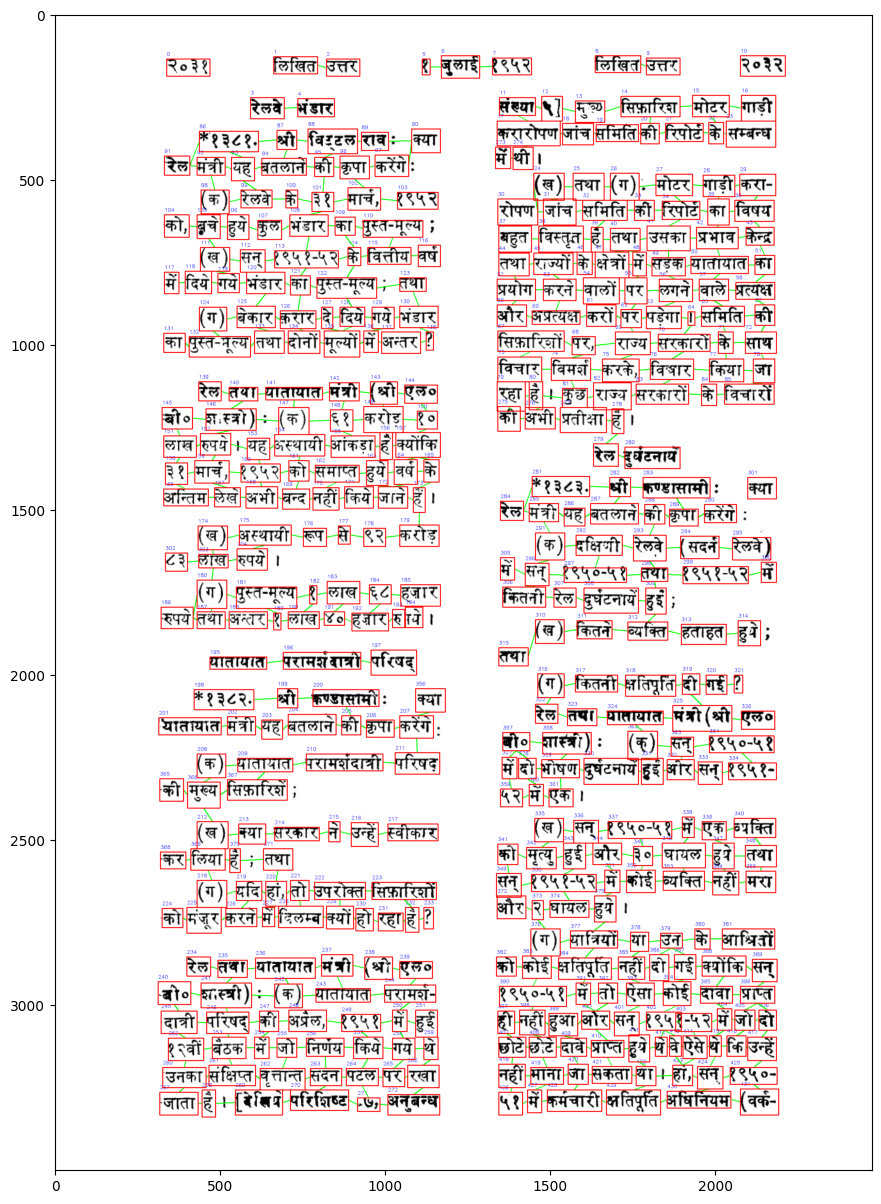

In [13]:
visualize_bboxes(make_connections(img, df_with_connections))

## Selecting threshold using hierarchical clustering

To select this threshold in a general manner, we use hierarchical clustering. We use the Euclidean distance between the centers of the edges of the bounding boxes as the distance metric with the `single` linkage method to find the clusters. We then consider the minimum distance between the clusters as the threshold. The number of clusters is set to be 20 but can be changed as a hyperparameter.

In [19]:
# def thresh_custom_distance(row1, row2):
#     top1, bottom1, left1, right1 = (row1[0], row1[1]), (row1[2], row1[3]), (row1[4], row1[5]), (row1[6], row1[7])
#     top2, bottom2, left2, right2 = (row2[0], row2[1]), (row2[2], row2[3]), (row2[4], row2[5]), (row2[6], row2[7])
# 
#     euclidean = lambda x1, x2: np.sqrt((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2)
#     return min(euclidean(top1, bottom2), euclidean(bottom1, top2), euclidean(left1, right2), euclidean(right1, left2))
# 
# def get_threshold_distance(frame, num_clusters):
#     cols = ['Top', 'Bottom', 'Left', 'Right']
#     data = frame[cols]
#     data = [[row[cols[0]][0], row[cols[0]][1], row[cols[1]][0], row[cols[1]][1],
#                  row[cols[2]][0], row[cols[2]][1], row[cols[3]][0], row[cols[3]][1]] for index, row in data.iterrows()]
#     data = np.array(data)
# 
#     linkage_matrix = linkage(data, method='single', metric=thresh_custom_distance)
# 
#     # Calculate the minimum distance between clusters
#     min_distance = linkage_matrix[data.shape[0] - num_clusters - 1, 2]
# 
#     return min_distance

def thresh_custom_distance(row1, row2):
    top1, bottom1, left1, right1 = (row1[0], row1[1]), (row1[2], row1[3]), (row1[4], row1[5]), (row1[6], row1[7])
    top2, bottom2, left2, right2 = (row2[0], row2[1]), (row2[2], row2[3]), (row2[4], row2[5]), (row2[6], row2[7])

    euclidean = lambda x1, x2: np.sqrt((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2)
    return min(euclidean(top1, bottom2), euclidean(bottom1, top2), euclidean(left1, right2), euclidean(right1, left2))

def get_threshold_distance(frame):
    cols = ['Top', 'Bottom', 'Left', 'Right']
    data = frame[cols].copy()
    data = [[row[cols[0]][0], row[cols[0]][1], row[cols[1]][0], row[cols[1]][1],
                 row[cols[2]][0], row[cols[2]][1], row[cols[3]][0], row[cols[3]][1]] for index, row in data.iterrows()]
    data = np.array(data)

    # Finding vertical distance threshold using elbow method
    linkage_matrix = linkage(data, method='single', metric=thresh_custom_distance)
    min_clusts = 8
    max_clusts = 25
    # Find difference between consecutive distances
    diff = np.diff(linkage_matrix[:, 2], 2)
    optimal_clusters = 8
    max_gap = 0
    for i in range(len(diff)-min_clusts, len(diff) - max_clusts, -1):
        if diff[i] > max_gap:
            max_gap = diff[i]
            optimal_clusters = len(diff) - i

    return linkage_matrix[len(diff) - optimal_clusters, 2]

In [20]:
thr = get_threshold_distance(df_fixed)
thr

59.43904440685432

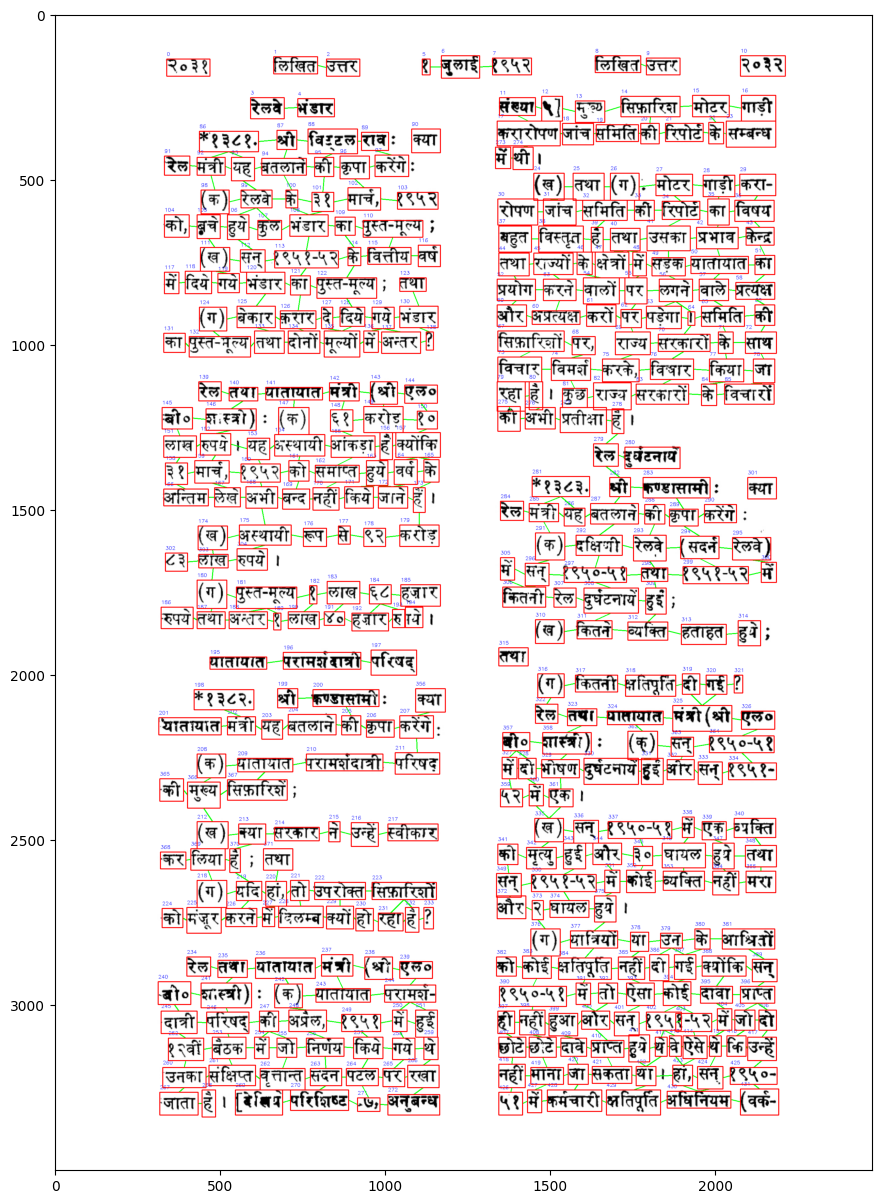

In [21]:
df_with_connections = add_connections(df_fixed, (thr, thr))
visualize_bboxes(make_connections(img, df_with_connections))

## Storing the results of the rest of the images

We store the resulting csv and images in 2 folders named `4-3-CSV-solutions` and `4-3-Images-solutions` respectively.

In [22]:
targets = [29, 68, 101, 145, 152, 159, 174, 201, 232, 250]
for t in targets:
    document_csv_path_ = 'SMAI - AQ2/CSV/TLBR_{}.csv'.format(t)
    df_ = pd.read_csv(document_csv_path_)
    df_fixed_ = add_columns(df_)
    # Find threshold
    thr_ = get_threshold_distance(df_fixed_)
    df_with_connections_ = add_connections(df_fixed_, (thr_, thr_))
    df_with_connections_.to_csv('4-3-CSV-solutions/TLBR_{}.csv'.format(t), index=False)
    cv2.imwrite('4-3-Images-solutions/{}.jpg'.format(t), make_connections(cv2.imread('SMAI - AQ2/images/{}.jpg'.format(t)), df_with_connections_))